# Example 2. WSBMs on simulated data

Here we demonstrate how VIRGMo can be used to fit different weighted SBMs to the synthetic data produced from the same model. This example follows Example 1 but with addition of edges' weights.

In [1]:
import torch
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import matplotlib.pyplot as plt
from virgmo.vi_sbm import VI_WSBM, VI_WDCSBM
from virgmo.graph_models import WSBM, WDCSBM, EdgesDataset
import seaborn as sns
sns.reset_orig()
torch.manual_seed(1553)

## WSBM

In [2]:
N = 200                              # Number of nodes
num_classes = 3                      # Number of classes
p = torch.tensor([0.2, 0.3, 0.5])    # Probability of each class
B = torch.tensor([                   # Connection probability between classes
        [0.8, 0.1, 0.3],
        [0.1, 0.9, 0.1],
        [0.5, 0.1, 0.8]])
w_mu = torch.tensor([                # Weight distributions means
            [10., 5., 2.],
            [5., 10., 2.],
            [2., 2., 20.]]).log()
w_tau = torch.ones([3,3])*100        # Weight distributions precision
wsbm = WSBM(p, B, w_mu, w_tau)
z, A = wsbm.generate(N)              # Generate the class assignments z and the adjacency matrix A

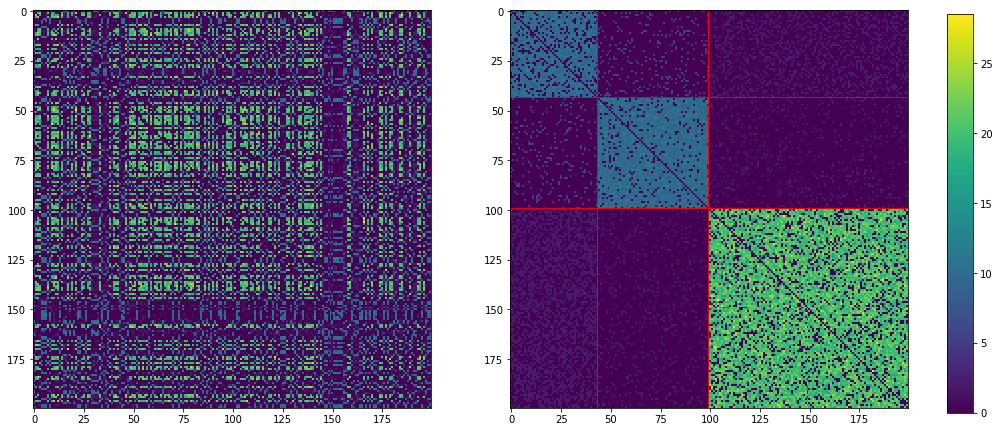

In [3]:
class_sizes = lambda classes: np.array(pd.Series(classes.numpy()).value_counts().sort_index())
cs = class_sizes(z.argmax(dim=1))
order = z.argmax(dim=1).argsort()
fig, axs = plt.subplots(1,2, figsize=(18,9))

axs[0].imshow(A.numpy(), cmap='viridis')
ax = axs[1].imshow(A[order,:][:,order].numpy(), cmap='viridis')
acc = -1
for i in cs[:-1]:
    acc += i
    axs[1].axvline(acc, color='r', linestyle='-', linewidth=1, alpha=0.9)
    axs[1].axhline(acc, color='r', linestyle='-', linewidth=1, alpha=0.9)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.188, 0.02, 0.615])
fig.colorbar(ax, cax=cbar_ax, aspect=30)
#plt.savefig('../examples/images/ex2_A_wsbm.pdf')
plt.show()

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 100031.48 | Epoch time 4.18
Epoch 2 | LR: 0.10 | Total loss: 75581.41 | Epoch time 4.59
Epoch 3 | LR: 0.10 | Total loss: 59350.63 | Epoch time 4.22
Epoch 4 | LR: 0.10 | Total loss: 52985.32 | Epoch time 3.95
Epoch 5 | LR: 0.10 | Total loss: 48908.96 | Epoch time 3.30
Epoch 6 | LR: 0.10 | Total loss: 44402.31 | Epoch time 2.41
Epoch 7 | LR: 0.10 | Total loss: 42988.08 | Epoch time 3.03
Epoch 8 | LR: 0.10 | Total loss: 42573.48 | Epoch time 3.26
Epoch 9 | LR: 0.10 | Total loss: 42372.07 | Epoch time 2.91
Epoch 10 | LR: 0.10 | Total loss: 42302.57 | Epoch time 2.58
Epoch 11 | LR: 0.05 | Total loss: 42260.77 | Epoch time 3.03
Epoch 12 | LR: 0.05 | Total loss: 42197.88 | Epoch time 2.93
Epoch 13 | LR: 0.05 | Total loss: 42211.45 | Epoch time 2.61
Epoch 14 | LR: 0.05 | Total loss: 42203.86 | Epoch time 3.15
Epoch 15 | LR: 0.05 | Total loss: 42164.31 | Epoch time 3.35
Epoch 16 | LR: 0.05 | Total loss: 42171.16 | Epoch time 3.39
E

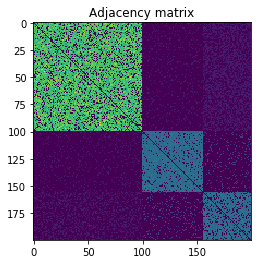

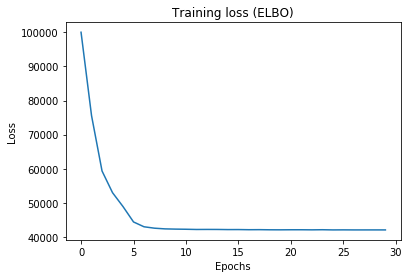

Latent class accuracy: 1.0
Classes probability [0.51 0.27 0.22]
Edges probability:
 [[0.81 0.1  0.49]
 [0.1  0.88 0.1 ]
 [0.31 0.11 0.8 ]]
Expected mean weight:
 [[3.02 0.68 0.68]
 [0.71 2.29 1.59]
 [0.68 1.61 2.29]]
Expected precision weight:
 [[94.81 67.81 81.18]
 [65.66 98.15 55.15]
 [85.58 47.56 76.62]]


In [5]:
dataloader = DataLoader(EdgesDataset(A), batch_size=N, shuffle=True, num_workers=0)
vi = VI_WSBM(num_nodes=N, num_classes=num_classes)
vi.train(dataloader, epochs=10, lrs=[0.1, 0.05, 0.01])
vi.summary(A, z)

In [6]:
q_eta, q_theta, q_B, q_w_mu, q_w_tau = vi.constrained_params()    # Get the parameters

In [7]:
permutation = [2,1,0]  # You may have to change the permutation
q_theta_perm = q_theta.detach()[permutation]
num_samples = 2000
theta_samples = Dirichlet(q_theta_perm).sample([num_samples])

In [8]:
sns.set()

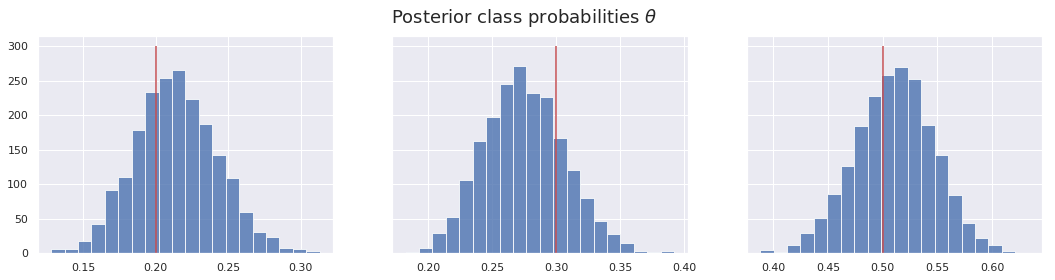

In [9]:
fig, axs = plt.subplots(1, num_classes, figsize=(18,4), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    axs[i].hist(theta_samples[:,i], bins=bins, alpha=alpha) 
    axs[i].vlines(p[i], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior class probabilities $\theta$', fontsize=18)
#plt.savefig('../examples/images/ex2_theta_wsbm.pdf')
plt.show()

In [10]:
q_B_perm = q_B.detach()[permutation,:,:][:,permutation,:]
B_samples = Beta(q_B_perm[:,:,0], q_B_perm[:,:,1]).sample([num_samples])

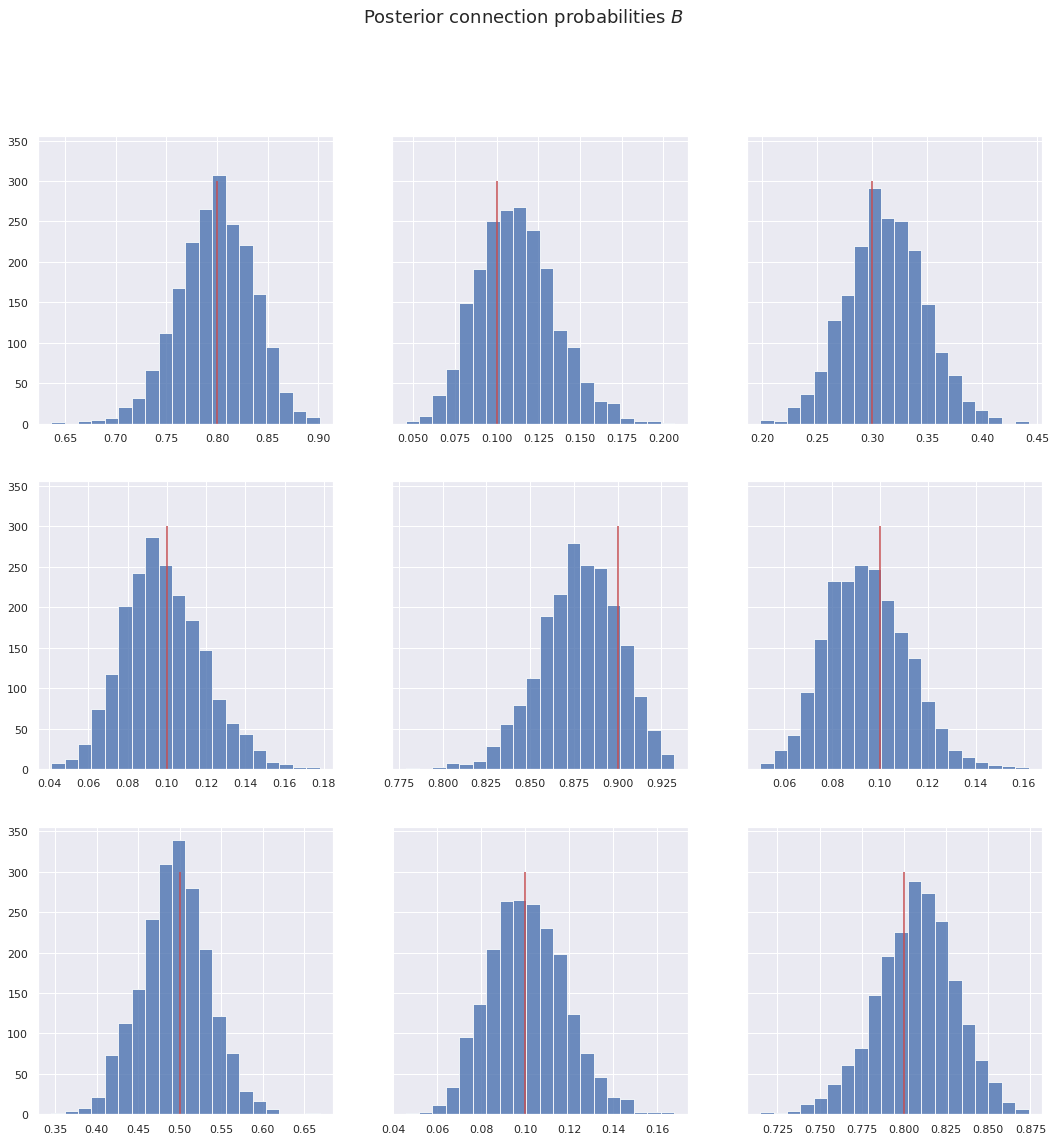

In [11]:
fig, axs = plt.subplots(num_classes, num_classes, figsize=(18,18), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
        axs[i,j].vlines(B[i,j], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior connection probabilities $B$', fontsize=18)
#plt.savefig('../examples/images/ex2_B_wsbm.pdf')
plt.show()

Now, let us compare sampled weights from the true and approximating distributions.

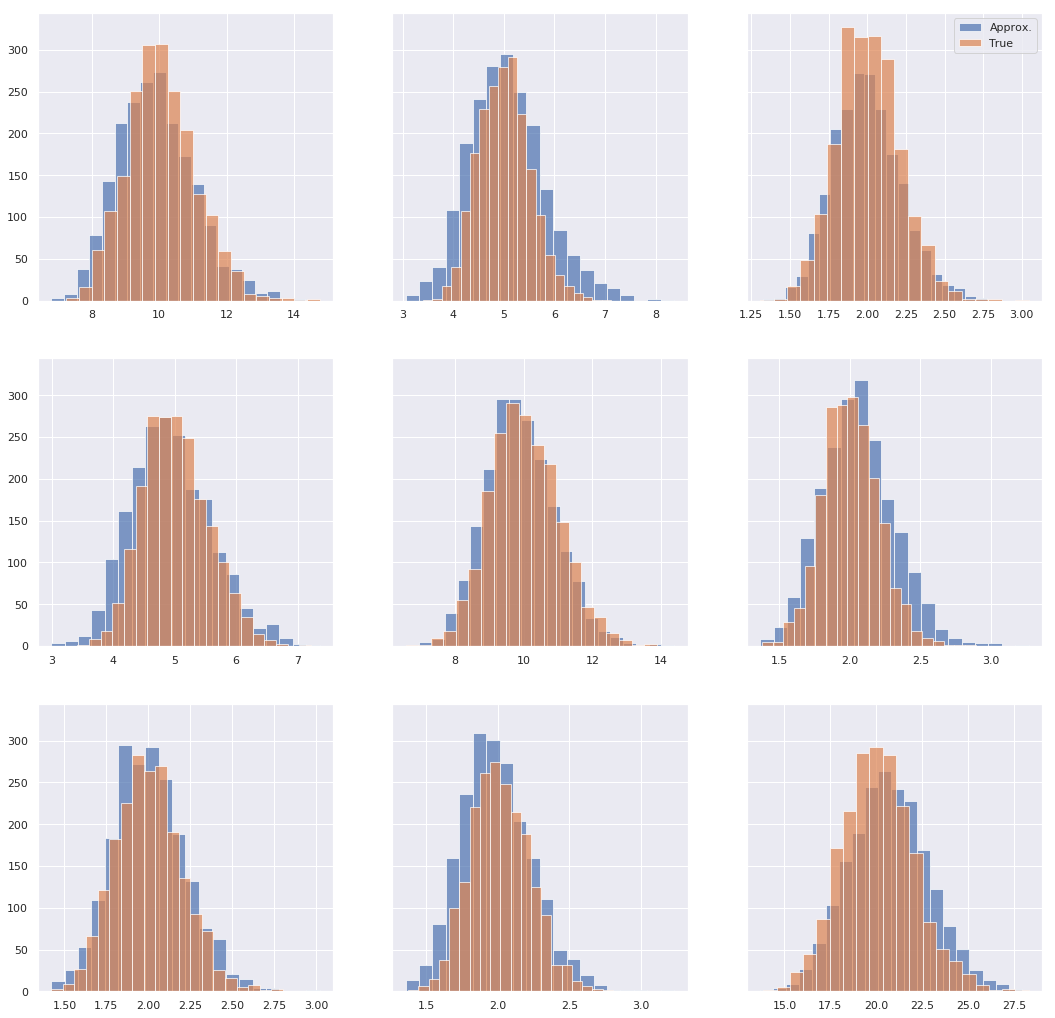

In [12]:
_,_,_, q_w_mu_mean, q_w_tau_mean = vi.qmean()    # Get the parameter means

from torch.distributions.log_normal import LogNormal
q_w_mu_mean_perm = q_w_mu_mean.detach()[permutation,:][:,permutation]
q_w_tau_mean_perm = q_w_tau_mean.detach()[permutation,:][:,permutation]
q_w_samples = LogNormal(q_w_mu_mean_perm, 1/q_w_tau_mean_perm.sqrt()).sample([num_samples])
p_w_samples = LogNormal(w_mu, 1/w_tau.sqrt()).sample([num_samples])
fig, axs = plt.subplots(num_classes, num_classes, figsize=(18,18), sharey=True)

bins, alpha = 20, 0.7
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(q_w_samples[:,i, j], bins=bins, alpha=alpha, label='Approx.') 
        axs[i,j].hist(p_w_samples[:,i, j], bins=bins, alpha=alpha, label='True') 
axs[0,2].legend()
#fig.suptitle(r'Weights distributions', fontsize=18)
plt.savefig('../examples/images/ex2_w_wsbm.pdf')
plt.show()

--------------------

## WDCSBM

In [13]:
sns.reset_orig()

In [36]:
N = 200                              # Number of nodes
num_classes = 3                      # Number of classes
p = torch.tensor([0.2, 0.3, 0.5])    # Probability of each class
B = torch.tensor([                   # Connection probability between classes
        [0.8, 0.1, 0.3],
        [0.1, 0.9, 0.1],
        [0.5, 0.1, 0.8]])
delta = torch.tensor(
    [[0.,1.], [0.,1.], [0.,1.]])     # Parameters of degree distributions
w_mu = torch.tensor([                # Weight distributions means
            [10., 5., 2.],
            [5., 10., 2.],
            [2., 2., 20.]]).log()
w_tau = torch.ones([3,3])*100        # Weight distributions precision
wdcsbm = WDCSBM(p, B, delta, w_mu, w_tau)
z, A = wdcsbm.generate(N)            # Generate the class assignments z and the adjacency matrix A

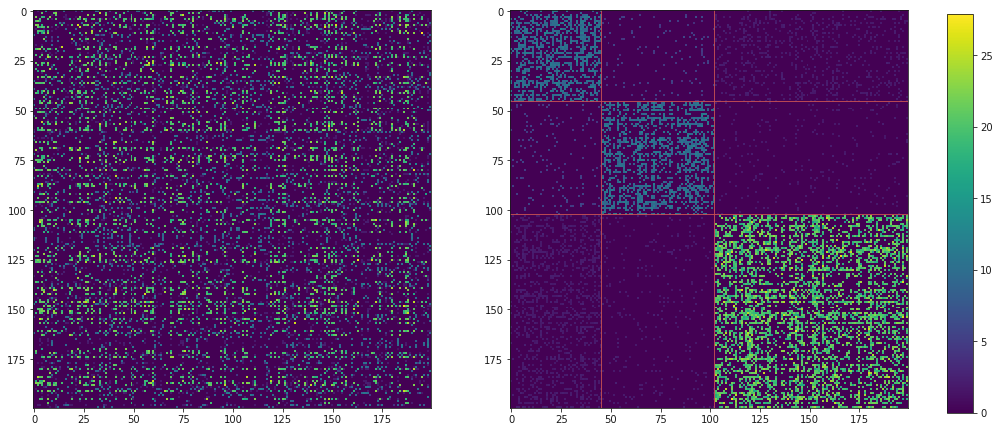

In [16]:
class_sizes = lambda classes: np.array(pd.Series(classes.numpy()).value_counts().sort_index())
cs = class_sizes(z.argmax(dim=1))
order = z.argmax(dim=1).argsort()
fig, axs = plt.subplots(1,2, figsize=(18,9))

axs[0].imshow(A.numpy(), cmap='viridis')
ax = axs[1].imshow(A[order,:][:,order].numpy(), cmap='viridis')
acc = -1
for i in cs[:-1]:
    acc += i
    axs[1].axvline(acc, color='r', linestyle='-', linewidth=1, alpha=0.9)
    axs[1].axhline(acc, color='r', linestyle='-', linewidth=1, alpha=0.9)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.188, 0.02, 0.615])
fig.colorbar(ax, cax=cbar_ax, aspect=30)
#plt.savefig('../examples/images/ex2_A_wdcsbm.pdf')
plt.show()

In [17]:
# Degree initialization
delta_init = torch.ones([N,2])
delta_mu = A.sum(dim=1)/A.sum(dim=1).mean()
delta_init[:,0]=delta_mu.log().clone()
print('Contains infinities:', bool(torch.isinf(delta_init).sum().item()))

Contains infinities: False


In [18]:
dataloader = DataLoader(EdgesDataset(A), batch_size=N, shuffle=True, num_workers=0)
vi = VI_WDCSBM(num_nodes=N, num_classes=num_classes,
              init_values={'etas':None, 
                              'thetas':None, 
                              'Bs':None, 
                              'deltas':delta_init,
                              'mus':None,
                              'taus':None})
vi.multi_train(dataloader, epochs=15, lrs=[0.1, 0.05, 0.01], trials=10)

>>>>>>> Start multi-training...
>>> Trial 1/10 | Final loss: 30900.20 | Trial time 164.68
>>> Trial 2/10 | Final loss: 30524.63 | Trial time 162.67
>>> Trial 3/10 | Final loss: 41757.28 | Trial time 160.22
>>> Trial 4/10 | Final loss: 27169.55 | Trial time 161.11
>>> Trial 5/10 | Final loss: 41742.43 | Trial time 168.66
>>> Trial 6/10 | Final loss: 41744.33 | Trial time 200.47
>>> Trial 7/10 | Final loss: 41743.52 | Trial time 231.77
>>> Trial 8/10 | Final loss: 30505.79 | Trial time 220.19
>>> Trial 9/10 | Final loss: 30512.35 | Trial time 125.88
>>> Trial 10/10 | Final loss: 30523.12 | Trial time 130.82


In [19]:
best_trial = vi.get_multi_losses()[:,-1].argmin()   # With the smallest loss ar the end

vi.load_state_dict(vi.state_dicts[best_trial])      # Load the parameters from the best trial
q_eta, q_theta, q_B, q_delta , q_w_mu, q_w_tau = vi.constrained_params()

vi.multi_results[1][best_trial]                     # Chose the correct permutation

tensor([0.4841, 0.2272, 0.2886])

In [27]:
permutation = [1,2,0]  # You may have to change the permutation
q_theta_perm = q_theta.detach()[permutation]
num_samples = 2000
theta_samples = Dirichlet(q_theta_perm).sample([num_samples])

In [28]:
import seaborn as sns
sns.set()

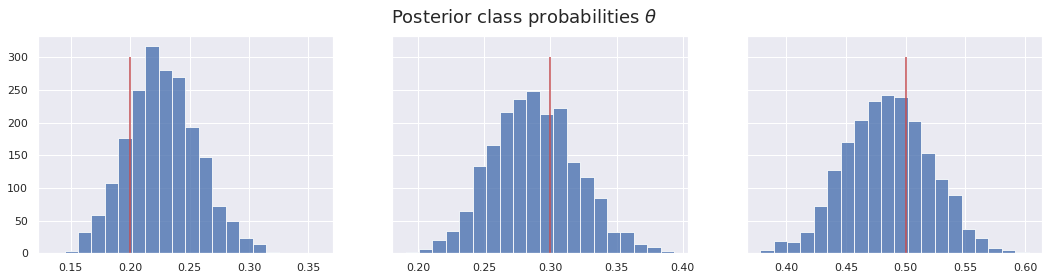

In [29]:
fig, axs = plt.subplots(1, num_classes, figsize=(18,4), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    axs[i].hist(theta_samples[:,i], bins=bins, alpha=alpha) 
    axs[i].vlines(p[i], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior class probabilities $\theta$', fontsize=18)
#plt.savefig('../examples/images/ex2_theta_wdcsbm.pdf')
plt.show()

In [30]:
print('Latent class accuracy:', vi.class_accuracy(z).numpy().item())

Latent class accuracy: 1.0


In [31]:
q_B_perm = q_B.detach()[permutation,:,:][:,permutation,:]
B_samples = Beta(q_B_perm[:,:,0], q_B_perm[:,:,1]).sample([num_samples])

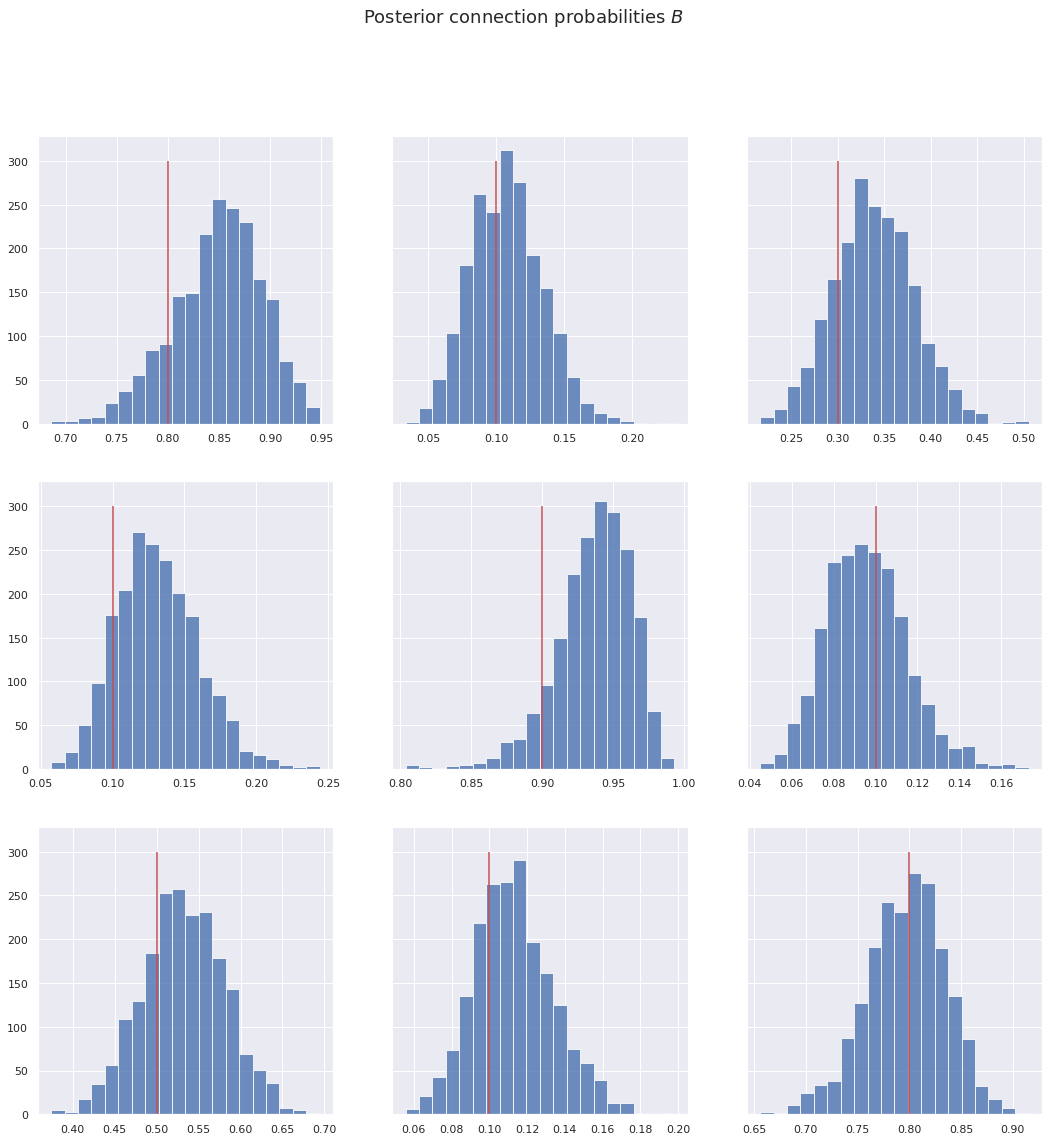

In [32]:
fig, axs = plt.subplots(num_classes, num_classes, figsize=(18,18), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
        axs[i,j].vlines(B[i,j], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior connection probabilities $B$', fontsize=18)
#plt.savefig('../examples/images/ex2_B_wdcsbm.pdf')
plt.show()

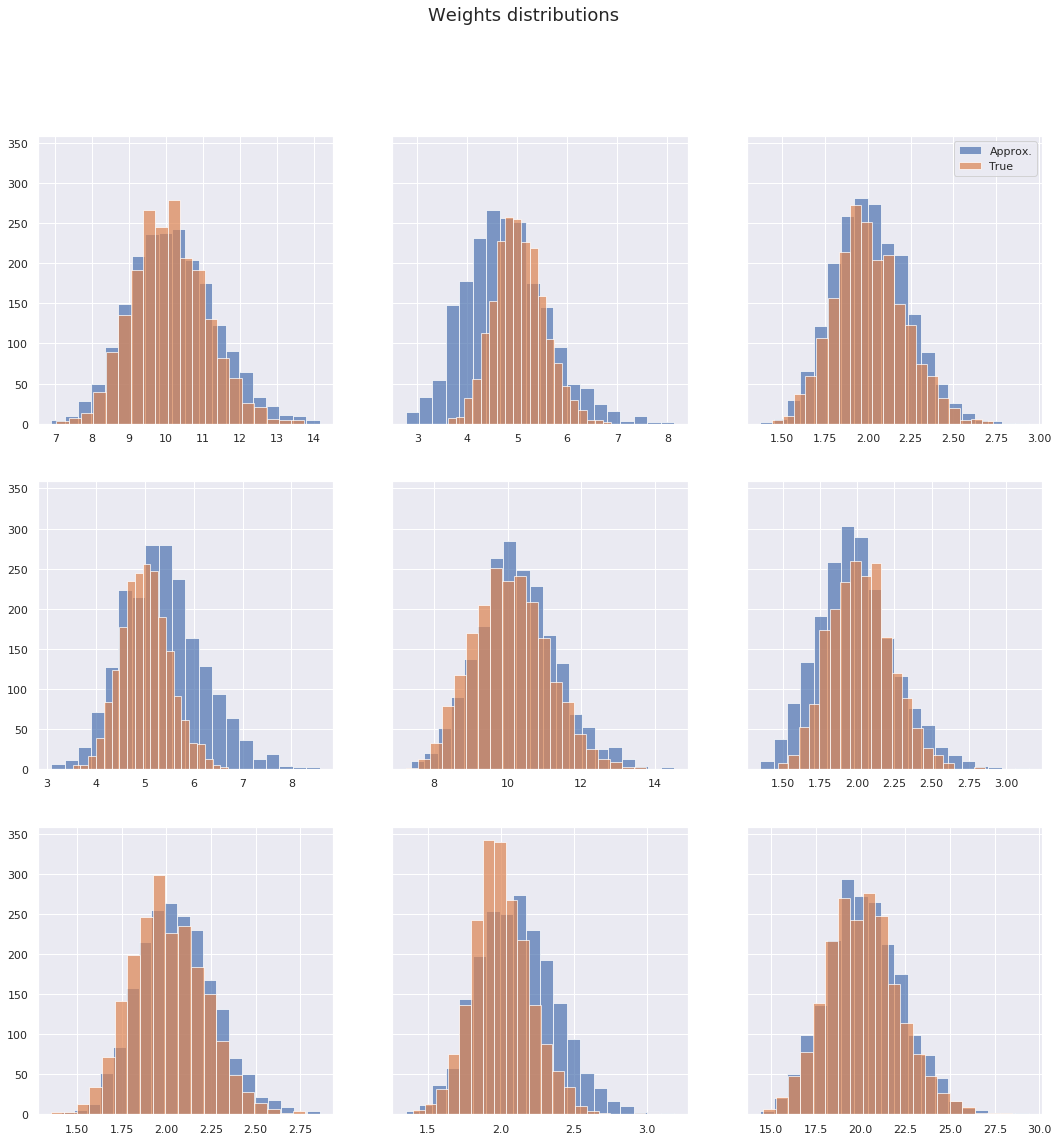

In [34]:
_,_,_,_, q_w_mu_mean, q_w_tau_mean = vi.qmean()    # Get the parameter means

from torch.distributions.log_normal import LogNormal
q_w_mu_mean_perm = q_w_mu_mean.detach()[permutation,:][:,permutation]
q_w_tau_mean_perm = q_w_tau_mean.detach()[permutation,:][:,permutation]
q_w_samples = LogNormal(q_w_mu_mean_perm, 1/q_w_tau_mean_perm.sqrt()).sample([num_samples])
p_w_samples = LogNormal(w_mu, 1/w_tau.sqrt()).sample([num_samples])
fig, axs = plt.subplots(num_classes, num_classes, figsize=(18,18), sharey=True)

bins, alpha = 20, 0.7
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(q_w_samples[:,i, j], bins=bins, alpha=alpha, label='Approx.') 
        axs[i,j].hist(p_w_samples[:,i, j], bins=bins, alpha=alpha, label='True') 
axs[0,2].legend()
fig.suptitle(r'Weights distributions', fontsize=18)
#plt.savefig('../examples/images/ex2_w_wdcsbm.pdf')
plt.show()